In [3]:
import os
import shutil
import random
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models, regularizers, backend as K

In [4]:
# ---------------------------
# PATH & PARAMETER
# ---------------------------
raw_data_dir = "D:\SKRIPSI\DATASET"
preprocessed_dir = "D:\SKRIPSI\Preprocessed"
split_data_dir = "D:\SKRIPSI\Split"
target_size = (224, 224)
batch_size = 32
num_classes = 4
epochs = 100

In [5]:
# ---------------------------
# 1. PREPROCESS (convert ke RGB, resize, normalisasi, save)
# ---------------------------
def preprocess_and_save(source_dir, dest_dir, target_size=(224, 224)):
    if not os.path.exists(dest_dir) or not os.listdir(dest_dir):
        for class_name in os.listdir(source_dir):
            src_path = os.path.join(source_dir, class_name)
            dst_path = os.path.join(dest_dir, class_name)
            os.makedirs(dst_path, exist_ok=True)

            for img_name in os.listdir(src_path):
                img_path = os.path.join(src_path, img_name)
                try:
                    img = Image.open(img_path).convert("RGB")  # paksa semua gambar jadi RGB
                    img = img.resize(target_size)

                    # Normalisasi piksel ke [0,1]
                    img_array = np.asarray(img).astype(np.float32) / 255.0

                    # Simpan kembali hasil normalisasi (RGB)
                    save_img = Image.fromarray((img_array * 255).astype(np.uint8))
                    save_path = os.path.join(dst_path, img_name)
                    save_img.save(save_path)
                except Exception as e:
                    print(f"Gagal memproses {img_path}: {e}")

        print(f"Preprocessing selesai dan disimpan : {dest_dir}")
    else:
        print(f"Preprocessed data sudah ada di: {dest_dir}")

In [6]:
# ---------------------------
# 2. SPLIT DATA (train/val/test)
# ---------------------------
def split_data(source_dir, dest_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    if not os.path.exists(os.path.join(dest_dir, 'train')) or not os.listdir(os.path.join(dest_dir, 'train')):
        for class_name in os.listdir(source_dir):
            src_class = os.path.join(source_dir, class_name)
            images = os.listdir(src_class)
            random.shuffle(images)
            total = len(images)
            train_end = int(train_ratio * total)
            val_end = train_end + int(val_ratio * total)

            for i, img_name in enumerate(images):
                subset = "train" if i < train_end else "val" if i < val_end else "test"
                dst_path = os.path.join(dest_dir, subset, class_name)
                os.makedirs(dst_path, exist_ok=True)
                shutil.copy(os.path.join(src_class, img_name), os.path.join(dst_path, img_name))

        print(f"Data telah di-split dan disimpan di: {dest_dir}")
    else:
        print(f"Data sudah ada di folder {dest_dir}, split tidak dilakukan.")

# ---------------------------
# JALANKAN
# ---------------------------
preprocess_and_save(raw_data_dir, preprocessed_dir, target_size=(224, 224))
split_data(preprocessed_dir, split_data_dir)

Preprocessed data sudah ada di: D:\SKRIPSI\Preprocessed
Data sudah ada di folder D:\SKRIPSI\Split, split tidak dilakukan.


In [5]:
import os
from PIL import Image

def check_image_color_modes(image_dirs):
    mode_count = {'RGB': 0, 'Grayscale': 0, 'Other': 0}
    error_files = []

    # Iterate through all directories in the list
    for image_dir in image_dirs:
        print(f"Memeriksa folder: {image_dir}")
        
        # Iterate through all images in the directory
        for root, dirs, files in os.walk(image_dir):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(root, file)

                    try:
                        # Buka gambar dengan PIL
                        with Image.open(img_path) as pil_img:
                            mode = pil_img.mode

                            if mode == 'RGB':
                                mode_count['RGB'] += 1
                            elif mode == 'L':  # Mode 'L' adalah Grayscale di PIL
                                mode_count['Grayscale'] += 1
                            else:
                                mode_count['Other'] += 1
                    except Exception as e:
                        error_files.append(f"Error loading {file}: {e}")

    # Print the results
    print("\n=== HASIL DETEKSI TIPE GAMBAR ===")
    for mode, count in mode_count.items():
        print(f"{mode}: {count} gambar")

    if error_files:
        print(f"\n❌ Gagal memproses beberapa file:")
        for error in error_files:
            print(f"- {error}")

# Ganti dengan tiga path dataset kamu
image_dirs = [
    "E:\DATASET",  # Contoh direktori, sesuaikan dengan data kamu
    "E:\Preprocessed",
    "E:\Split"
]

# Panggil fungsi untuk memeriksa mode gambar
check_image_color_modes(image_dirs)


Memeriksa folder: E:\DATASET
Memeriksa folder: E:\Preprocessed
Memeriksa folder: E:\Split

=== HASIL DETEKSI TIPE GAMBAR ===
RGB: 24861 gambar
Grayscale: 0 gambar
Other: 0 gambar


In [5]:
def check_normalized_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('jpg', 'jpeg', 'png')):
                img_path = os.path.join(root, file)
                img = Image.open(img_path).convert('RGB')
                img = img.resize((224, 224))  # Sesuai ukuran target
                img_array = np.array(img).astype(np.float32) / 255.0  # Normalisasi sementara

                if not ((img_array >= 0.0).all() and (img_array <= 1.0).all()):
                    print(f"[!] Gambar TIDAK ter-normalisasi: {img_path}")
                    return False
    print("✅ Semua gambar sudah dalam rentang normalisasi (0.0–1.0)")
    return True

#direktori val dan test
val_ok = check_normalized_images(os.path.join(split_data_dir, 'val'))
test_ok = check_normalized_images(os.path.join(split_data_dir, 'test'))


✅ Semua gambar sudah dalam rentang normalisasi (0.0–1.0)
✅ Semua gambar sudah dalam rentang normalisasi (0.0–1.0)


In [7]:
# ---------------------------
# 3. DATA GENERATOR (tanpa rescale)
# ---------------------------

train_gen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.2,
    brightness_range=[0.6, 1.4],
    channel_shift_range=30.0,
    fill_mode='nearest'
)

val_test_gen = ImageDataGenerator()  # Tidak pakai rescale

train_generator = train_gen.flow_from_directory(
    os.path.join(split_data_dir, "train"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_test_gen.flow_from_directory(
    os.path.join(split_data_dir, "val"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator = val_test_gen.flow_from_directory(
    os.path.join(split_data_dir, "test"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 5800 images belonging to 4 classes.
Found 1243 images belonging to 4 classes.
Found 1244 images belonging to 4 classes.


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, backend as K

# ---------------------------
# BOTTLENECK BLOCK (ResNet50/101/152)
# ---------------------------
def bottleneck_block(x, filters, stride=1, downsample=False):
    shortcut = x

    # 1x1
    x = layers.Conv2D(filters, 1, strides=stride, padding='same',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 3x3
    x = layers.Conv2D(filters, 3, strides=1, padding='same',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 1x1
    x = layers.Conv2D(filters * 4, 1, strides=1, padding='same',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)

    if downsample or shortcut.shape[-1] != filters * 4:
        shortcut = layers.Conv2D(filters * 4, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

# ---------------------------
# BUILD RESNET101 MODEL
# ---------------------------
def build_resnet101(input_shape=(224, 224, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Conv2_x: 3 bottleneck blocks
    for i in range(3):
        x = bottleneck_block(x, 64, stride=1, downsample=(i == 0))

    # Conv3_x: 4 bottleneck blocks
    for i in range(4):
        x = bottleneck_block(x, 128, stride=2 if i == 0 else 1, downsample=(i == 0))

    # Conv4_x: 23 bottleneck blocks
    for i in range(23):
        x = bottleneck_block(x, 256, stride=2 if i == 0 else 1, downsample=(i == 0))

    # Conv5_x: 3 bottleneck blocks
    for i in range(3):
        x = bottleneck_block(x, 512, stride=2 if i == 0 else 1, downsample=(i == 0))

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

# ---------------------------
# FOCAL LOSS FUNCTION
# ---------------------------
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

# ---------------------------
# COMPILE MODEL
# ---------------------------
model = build_resnet101(input_shape=(224, 224, 3), num_classes=4)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=focal_loss(),
              metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 112, 112, 64)         0         ['batch_normalization[0][0

In [16]:
# ---------------------------
# 5. CALLBACKS
# ---------------------------
checkpoint = ModelCheckpoint('Model Terbaik_Tahap 1_resnet101.h5', monitor='val_accuracy', save_best_only=True)
checkpoint_keras = ModelCheckpoint('Model Terbaik_Tahap 1 keras.keras', monitor='val_accuracy', save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)


In [ ]:
# ---------------------------
# 6. TRAINING
# ---------------------------
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/100
182/182 [==============================] - ETA: 0s - loss: 3.6276 - accuracy: 0.2941 

C:\Users\user\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


182/182 [==============================] - 2129s 12s/step - loss: 3.6276 - accuracy: 0.2941 - val_loss: 3.6346 - val_accuracy: 0.2470 - lr: 1.0000e-04
Epoch 2/100
182/182 [==============================] - 2078s 11s/step - loss: 3.5034 - accuracy: 0.3440 - val_loss: 3.5547 - val_accuracy: 0.2591 - lr: 1.0000e-04
Epoch 3/100
182/182 [==============================] - 2087s 11s/step - loss: 3.4261 - accuracy: 0.3552 - val_loss: 3.3853 - val_accuracy: 0.3500 - lr: 1.0000e-04
Epoch 4/100
182/182 [==============================] - 2079s 11s/step - loss: 3.3358 - accuracy: 0.3822 - val_loss: 3.3209 - val_accuracy: 0.2848 - lr: 1.0000e-04
Epoch 5/100
182/182 [==============================] - 2082s 11s/step - loss: 3.2368 - accuracy: 0.3924 - val_loss: 3.1890 - val_accuracy: 0.3644 - lr: 1.0000e-04
Epoch 6/100
182/182 [==============================] - 2083s 11s/step - loss: 3.1300 - accuracy: 0.4036 - val_loss: 3.1035 - val_accuracy: 0.3990 - lr: 1.0000e-04
Epoch 7/100
182/182 [=============

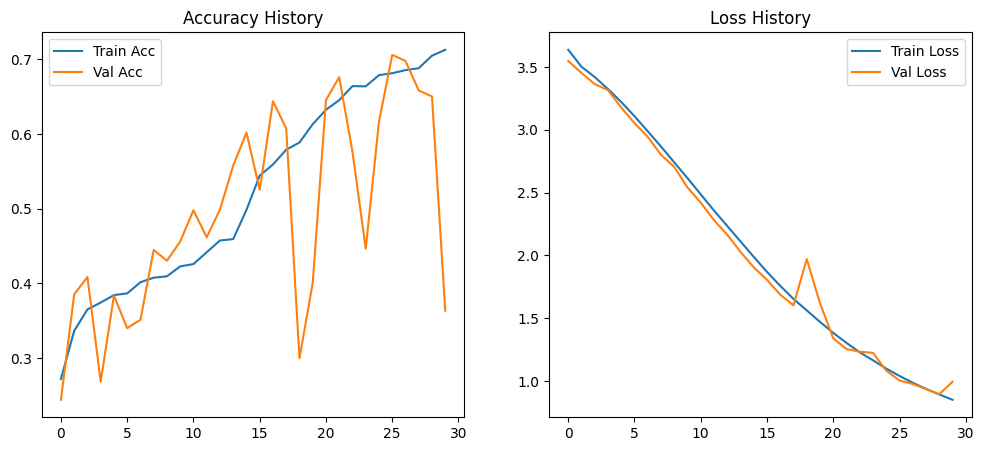

In [11]:
# ---------------------------
# 7. PLOT TRAINING
# ---------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy History')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss History')
plt.show()

39/39 [==============================] - 90s 2s/step
Classification Report:
                   precision    recall  f1-score   support

Asiatic-Mongoloid       0.00      0.00      0.00       300
  Kaukasoid-Indic       0.00      0.00      0.00       332
Malayan-Mongoloid       0.31      0.11      0.16       304
       Melanesoid       0.22      0.83      0.35       308

         accuracy                           0.23      1244
        macro avg       0.13      0.23      0.13      1244
     weighted avg       0.13      0.23      0.13      1244



C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


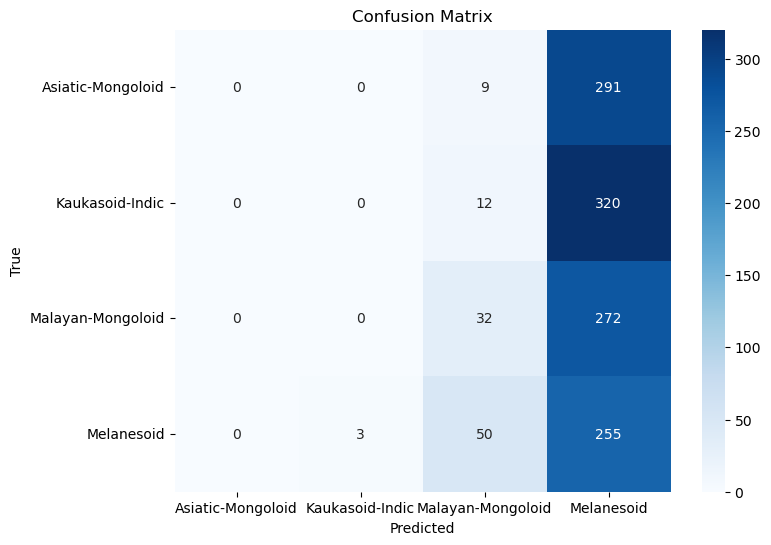

In [15]:
# ---------------------------
# 8. EVALUASI MODEL
# ---------------------------
y_true = test_generator.classes
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)

labels = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

39/39 [==============================] - 92s 2s/step
Classification Report:
                   precision    recall  f1-score   support

Asiatic-Mongoloid       0.93      0.87      0.90       300
  Kaukasoid-Indic       0.65      0.92      0.76       332
Malayan-Mongoloid       0.85      0.60      0.70       304
       Melanesoid       0.91      0.82      0.86       308

         accuracy                           0.81      1244
        macro avg       0.83      0.80      0.81      1244
     weighted avg       0.83      0.81      0.81      1244



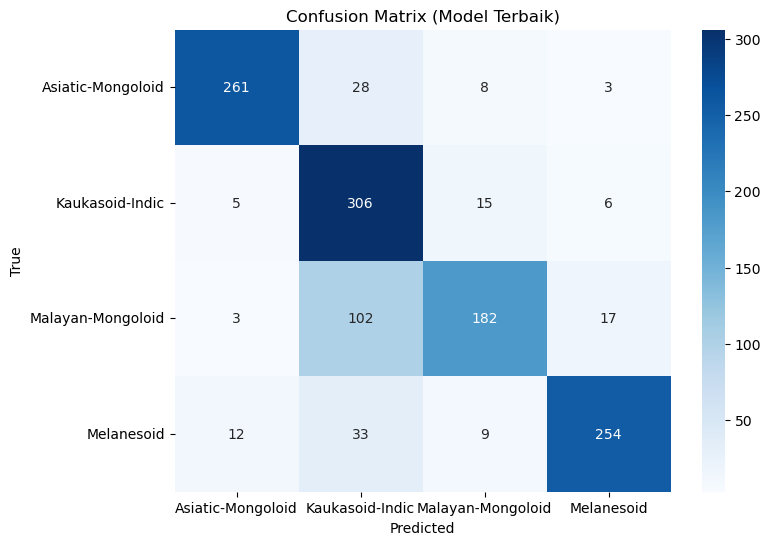

In [9]:
from tensorflow.keras.models import load_model

best_model = load_model(r"C:\Users\user\Downloads\Model Terbaik_Tahap 1_resnet101.h5", custom_objects={'focal_loss_fixed': focal_loss(gamma=2.0, alpha=0.25)})


# 2. Prediksi pakai model terbaik
y_true = test_generator.classes
y_prob = best_model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)

# 3. Buat label
labels = list(test_generator.class_indices.keys())

# 4. Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# 5. Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Model Terbaik)")
plt.show()


NameError: name 'history' is not defined

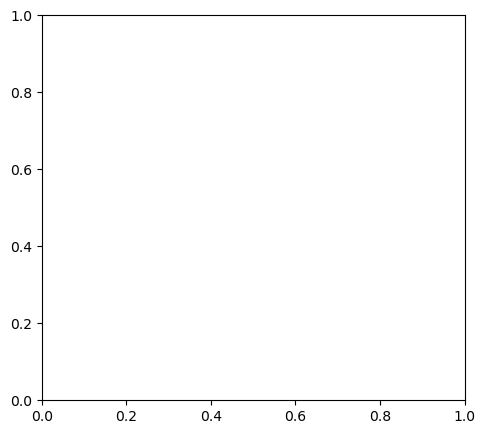

In [14]:
# ---------------------------
# 7. PLOT TRAINING (MODEL TERBAIK)
# ---------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.axvline(x=np.argmax(history.history['val_accuracy']), color='r', linestyle='--', label='Best Model')
plt.legend()
plt.title('Accuracy History (Best Model at Epoch {})'.format(np.argmax(history.history['val_accuracy']) + 1))

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.axvline(x=np.argmin(history.history['val_loss']), color='r', linestyle='--', label='Best Model (Loss)')
plt.legend()
plt.title('Loss History (Lowest Val Loss at Epoch {})'.format(np.argmin(history.history['val_loss']) + 1))

plt.show()
